<a href="https://colab.research.google.com/github/davidmorrison-08-30/Logistic-Regression-from-scratch/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**PREPARATION**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt, exp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def gradient(X: np.ndarray, y: np.ndarray, beta: np.ndarray):        
  '''Calculating gradient of sum of joint likelihood
  '''
  sigmoid = 1/(1+np.exp(-np.dot(X, beta)))
  return np.dot(X.T, sigmoid-y)

In [5]:
# rate of error in prediction
def error_rate(prediction, actual):
  num_of_points = len(prediction)
  num_of_errors = 0
  for i in range(num_of_points):
    if prediction[i] != actual[i]: num_of_errors += 1
  return num_of_errors/num_of_points

In [6]:
# pseudo "r2 score" for logistic regression model, using McFadden's r2_score
def r2_score(X: np.ndarray, y: np.ndarray, beta):
    score1 = np.dot(X, beta).reshape(1, X.shape[0])
    full_log = np.sum(-np.log(1 + np.exp(score1))) + np.sum(y*score1)
    z = np.array([beta if i == 0 else 0.0 for i, beta in enumerate(beta.reshape(1, X.shape[1])[0])]).reshape(X.shape[1], 1)
    score2 = np.dot(X, z).reshape(1, X.shape[0])
    null_log = np.sum(-np.log(1 + np.exp(score2))) + np.sum(y*score2)
    return 1.0 - (full_log / null_log)

In [7]:
class LogisticRegression:
  def __init__(self, learning_rate):
    self.beta = None
    self.lr = learning_rate
  
  def predict(self, X: np.ndarray):
    sigmoid = 1/(1+np.exp(-np.dot(X, self.beta)))
    category = np.ones(shape=sigmoid.shape)
    for i in range(len(category)):
      if sigmoid[i] < 0.5: category[i] = 0
    return category

  def fit(self, X, y):
   # self.beta = np.random.randint(low=500, high=1000, size=(X.shape[1], 1))
    self.beta = np.zeros(shape=(X.shape[1], 1))
    self.beta = self.beta.astype(float)
    for iter in range(10000):
      grad = gradient(X, y, self.beta)
      self.beta = self.beta - grad*self.lr

## **DATA PREPROCESSING**

In [8]:
# read data
df = pd.read_csv("gdrive/My Drive/framingham.csv")

In [9]:
df.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [10]:
df.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [11]:
# filling null values in a column with the average of that column
df = df.fillna(df.mean())

In [12]:
df.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [13]:
df.shape

(4238, 16)

In [14]:
df.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.00000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.02963,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.007075,0.500024,11.879230,0.16852,0.076587,0.462763,0.158316,44.326453,22.038097,11.910850,4.070953,12.025177,22.836603,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.080000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,80.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.00000,0.000000,1.000000,0.000000,262.000000,144.000000,89.875000,28.037500,83.000000,85.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.00000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4238 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4238 non-null   float64
 5   BPMeds           4238 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4238 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4238 non-null   float64
 13  heartRate        4238 non-null   float64
 14  glucose          4238 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


## **DATA UNDERSTANDING**

<AxesSubplot:>

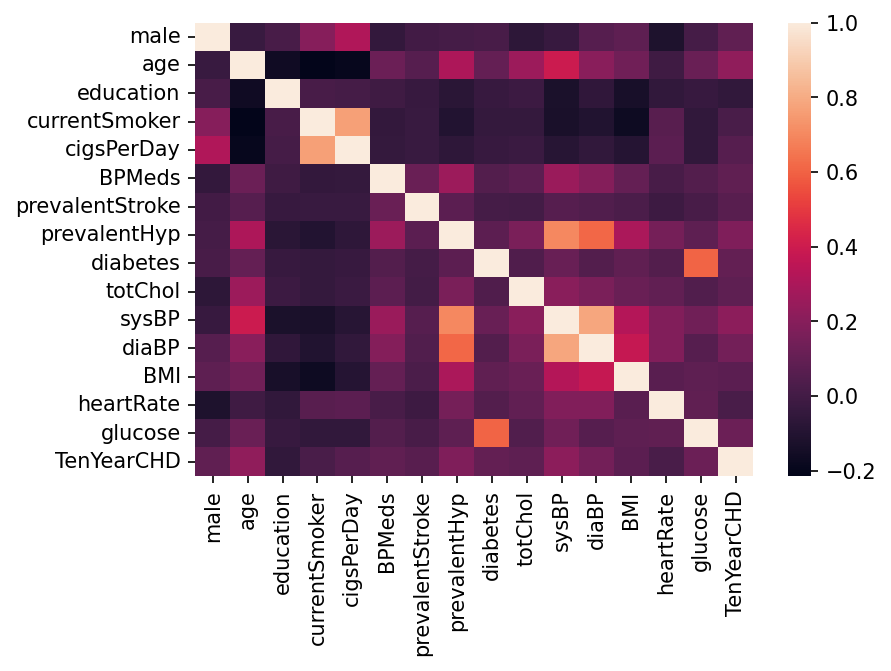

In [16]:
plt.figure(dpi=150)
sns.heatmap(df.corr(),annot=False)

In [17]:
X = df.drop("TenYearCHD", axis=1)
y = df["TenYearCHD"].to_numpy()

In [18]:
y = np.reshape(y, (y.shape[0], 1))

## **DATA SCALING**

In [19]:
X = np.concatenate((np.ones(shape=(X.shape[0], 1)), X), axis=1)

In [20]:
std_scaler = MinMaxScaler()
X = std_scaler.fit_transform(X)

In [21]:
X

array([[0.        , 1.        , 0.18421053, ..., 0.27702375, 0.36363636,
        0.10451977],
       [0.        , 0.        , 0.36842105, ..., 0.31968008, 0.51515152,
        0.10169492],
       [0.        , 1.        , 0.42105263, ..., 0.23751818, 0.31313131,
        0.08474576],
       ...,
       [0.        , 0.        , 0.42105263, ..., 0.1565681 , 0.4040404 ,
        0.1299435 ],
       [0.        , 0.        , 0.31578947, ..., 0.08773631, 0.42424242,
        0.11855015],
       [0.        , 0.        , 0.52631579, ..., 0.14372273, 0.36363636,
        0.18926554]])

## **TRAINING & EVALUATION**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model = LogisticRegression(0.001)

In [24]:
model.fit(X_train, y_train)

In [25]:
print(model.beta)

[[ 0.        ]
 [ 0.16231204]
 [ 1.09855115]
 [-0.49628382]
 [-0.52938754]
 [ 1.96341846]
 [ 0.45800747]
 [ 0.71416222]
 [ 0.74434381]
 [ 1.00055475]
 [-3.14985253]
 [ 3.51125944]
 [-2.64797076]
 [-2.67662413]
 [-2.76816512]
 [-0.34992206]]


In [26]:
y_train_pred = model.predict(X_train)
error_rate(y_train_pred, y_train)

0.15073746312684366

In [27]:
beta = model.beta[:]
print(r2_score(X_train, y_train, beta))

-1339.645474582663


In [28]:
y_test_pred = model.predict(X_test)
error_rate(y_test_pred, y_test)

0.14504716981132076

In [29]:
print(r2_score(X_test, y_test, beta))

-310.55355452678293


## **CONFUSION MATRIX**

In [30]:
# training dataset
cf_train = confusion_matrix(y_train, y_train_pred)

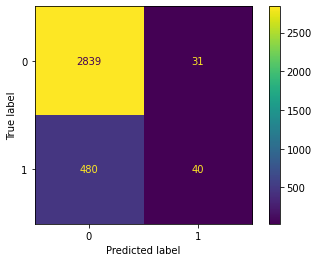

In [31]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_train, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [32]:
# testing dataset
cf_test = confusion_matrix(y_test, y_test_pred)

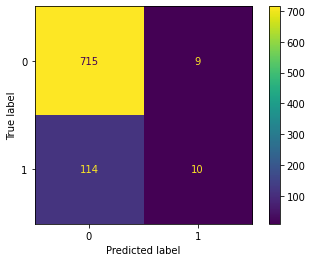

In [33]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_test, display_labels = [0, 1])
cm_display.plot()
plt.show()